Classify using Deep Learning

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [150]:
from tensorflow.python import keras
print(keras.__version__)

2.4.0


In [2]:
inoutpath = '/home/xiaopengxu/Desktop/data-covid-review/2021-05-31/'

train_data_path = inoutpath + 'features.ori_doc2vec_deepwalk_scores_train.csv'
test_data_path = inoutpath + 'features.ori_doc2vec_deepwalk_scores_test.csv'

epochs = 5

## Load data

In [3]:
def load_data(compdata_path):
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f') + ": Loading data ...")
    papers = pd.read_csv(compdata_path, index_col=False)
    papers.drop(['Unnamed: 0'], axis=1, inplace=True)

    return papers.fillna(0)

In [4]:
X = load_data(train_data_path)
X_lxd = load_data(test_data_path)

2021-06-03 17:18:18.717134: Loading data ...
2021-06-03 17:18:19.502020: Loading data ...


/home/xiaopengxu/anaconda3/envs/ml-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [5]:
y = X.is_published

In [6]:
print(X.columns.values)

['title' 'abstract' 'journal' 'DOI' 'date' 'collection' 'published'
 'nauthors' 'keywords' 'topic.Imaging' 'topic.Clinics'
 'topic.Drug discovery' 'topic.Healthcare' 'topic.Genomics'
 'topic.Epidemiology' 'topic' 'ref' 'p_doi' 'dv 1' 'dv 2' 'dv 3' 'dv 4'
 'dv 5' 'dv 6' 'dv 7' 'dv 8' 'dv 9' 'dv 10' 'dv 11' 'dv 12' 'dv 13'
 'dv 14' 'dv 15' 'dv 16' 'dv 17' 'dv 18' 'dv 19' 'dv 20' 'dv 21' 'dv 22'
 'dv 23' 'dv 24' 'dv 25' 'dv 26' 'dv 27' 'dv 28' 'dv 29' 'dv 30' 'dv 31'
 'dv 32' 'dv 33' 'dv 34' 'dv 35' 'dv 36' 'dv 37' 'dv 38' 'dv 39' 'dv 40'
 'dv 41' 'dv 42' 'dv 43' 'dv 44' 'dv 45' 'dv 46' 'dv 47' 'dv 48' 'dv 49'
 'dv 50' 'dw 1' 'dw 2' 'dw 3' 'dw 4' 'dw 5' 'dw 6' 'dw 7' 'dw 8' 'dw 9'
 'dw 10' 'dw 11' 'dw 12' 'dw 13' 'dw 14' 'dw 15' 'dw 16' 'dw 17' 'dw 18'
 'dw 19' 'dw 20' 'dw 21' 'dw 22' 'dw 23' 'dw 24' 'dw 25' 'dw 26' 'dw 27'
 'dw 28' 'dw 29' 'dw 30' 'dw 31' 'dw 32' 'dw 33' 'dw 34' 'dw 35' 'dw 36'
 'dw 37' 'dw 38' 'dw 39' 'dw 40' 'dw 41' 'dw 42' 'dw 43' 'dw 44' 'dw 45'
 'dw 46' 'dw 47' 'dw 

## Train DL model

In [184]:
def create_model(n_features, layers):
    # create model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(layers[0], input_dim=n_features, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)))

    # add hidden layers
    for i in range(1, len(layers)):
        #model.add(tf.keras.layers.Dense(layers[i], activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1)))
        model.add(tf.keras.layers.Dense(layers[i], activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
    return model

In [185]:
def eval_pred(y_true, y_prob, eval_type='Dev'):

    y_pred = y_prob >= 0.5
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_s = auc(fpr, tpr)

    prec, recall, f1_s, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    
    print(eval_type + ": AUC = %.3f, precision = %.3f, recall = %.3f, accuracy = %.3f, f1_score = %.3f" % (auc_s, prec, recall, acc, f1_s))

In [186]:
def dl_modeling(model_name, save_path, X_train, X_test, y_train, y_test, features, layers, epochs=10, batch_size=64):
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f') + ": Training {} model ...".format(model_name))
    model = create_model(len(features), layers)
    md = model.fit(X_train[features], y_train, epochs=epochs, batch_size=64)
    model.save(save_path + "model." + model_name + ".dl")

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f') + ": Evaluating {} model ...".format(model_name))
    y_test_prob = model.predict(X_test[features])
    
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    auc_dl = auc(fpr, tpr)
    eval_pred(y_train, model.predict(X_train[features]), 'Train')
    eval_pred(y_test, y_test_prob, 'Dev')
    
    return fpr, tpr, auc_dl

In [187]:
def draw_ROC_figure(fprs, tprs, f_names, aucs, save_path):
    plt.figure()
    plt.rcParams['figure.figsize'] = [10, 10]
    
    for i in range(len(f_names)):
        plt.plot(fprs[i], tprs[i], label= f_names[i] +', AUC={:.4f}'.format(aucs[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    fig1 = plt.gcf()
    plt.draw()
    fig1.savefig(save_path + "features_rocs.pdf")

In [372]:
def feature_comparison(X_train, X_test, y_train, y_test, save_path, epochs=10):
    
    em_size = 50
    F_Doc2Vec = ['dv ' + str(i + 1) for i in range(em_size)]
    F_DeepWalk = ['dw ' + str(i + 1) for i in range(em_size)]
    F_LDA = ['topic.Healthcare', 'topic.Drug discovery', 'topic.Epidemiology', 'topic.Clinics', 'topic.Imaging', 'topic.Genomics']
    F_ascore = ['auth.papers.score', 'auth.citations.score']
    
    f_names = [
        'LDA+Doc2Vec+DeepWalk', 
        'Doc2Vec+DeepWalk', 
        #'Doc2Vec+LDA', 
        #'Doc2Vec', 
        #'LDA', 
        #'DeepWalk', 
    ]
    f_combs = [
        F_Doc2Vec + F_DeepWalk + F_LDA, 
        F_Doc2Vec + F_DeepWalk, 
        #F_Doc2Vec + F_LDA, 
        #F_Doc2Vec, 
        #F_LDA, 
        #F_DeepWalk
    ]
    layers = [
        [150, 30, 6, 9], 
        [150, 9, 20, 10], 
        #[150, 9, 20, 10],
        #[100, 50, 30, 10], 
        #[10, 50, 3, 9], 
        #[150, 6, 20, 3]
    ]
    
    fprs, tprs, aucs = [], [], []
    
    for i in range(len(f_names)):
        fpr, tpr, auc = dl_modeling(f_names[i], save_path, X_train, X_test, y_train, y_test, f_combs[i], layers[i], epochs=epochs)
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc)
        
    draw_ROC_figure(fprs, tprs, f_names, aucs, save_path)

12971
3243
2021-06-08 15:39:47.500075: Training LDA+Doc2Vec+DeepWalk model ...
Epoch 1/5
203/203 [==============================] - 1s 2ms/step - loss: 6.3957 - accuracy: 0.7335
Epoch 2/5
203/203 [==============================] - 0s 2ms/step - loss: 0.5292 - accuracy: 0.7694
Epoch 3/5
203/203 [==============================] - 0s 2ms/step - loss: 0.5044 - accuracy: 0.7797
Epoch 4/5
203/203 [==============================] - 0s 2ms/step - loss: 0.4913 - accuracy: 0.7857
Epoch 5/5
203/203 [==============================] - 0s 2ms/step - loss: 0.4838 - accuracy: 0.7939
INFO:tensorflow:Assets written to: /home/xiaopengxu/Desktop/data-covid-review/2021-05-31/model.LDA+Doc2Vec+DeepWalk.dl/assets
2021-06-08 15:39:51.064789: Evaluating LDA+Doc2Vec+DeepWalk model ...
Train: AUC = 0.799, precision = 0.807, recall = 0.609, accuracy = 0.792, f1_score = 0.621
Dev: AUC = 0.791, precision = 0.822, recall = 0.610, accuracy = 0.788, f1_score = 0.620
2021-06-08 15:39:51.431369: Training Doc2Vec+DeepWal

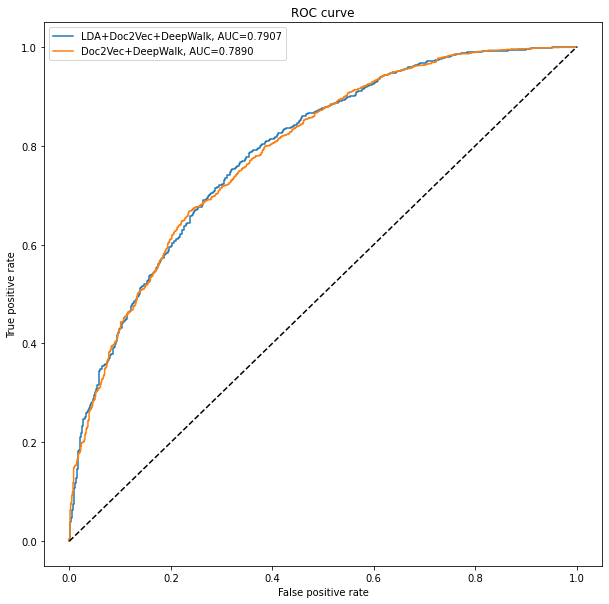

In [376]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#X_train.to_csv(inoutpath + 'training_set.csv')
#X_test.to_csv(inoutpath + 'testing_set.csv')
X_train = pd.read_csv(inoutpath + 'training_set.csv')
X_test = pd.read_csv(inoutpath + 'testing_set.csv')

print(len(X_train))
print(len(X_test))

feature_comparison(X_train, X_test, X_train.is_published, X_test.is_published, inoutpath, epochs=5)

In [379]:
F_new = F_Doc2Vec + F_DeepWalk + F_LDA
#F_new = F_Doc2Vec + F_DeepWalk

model = load_model(inoutpath, 'LDA+Doc2Vec+DeepWalk_selected')
#model = load_model(inoutpath, 'Doc2Vec+DeepWalk')

X['pub_prob'] = model.predict(X[F_new])
#X_test['pub_prob'] = model.predict(X_test[F_new]) # dev data
X_lxd['pub_prob'] = model.predict(X_lxd[F_new]) # target data

pd.set_option('display.max_colwidth', None)
X_lxd[X_lxd.title.isin(selected)][['title', 'pub_prob']].sort_values(by='pub_prob', ascending=False)

,title,pub_prob
590,structural analysis of spike protein mutations in an emergent sars-cov-2 variant from the philippines,0.881821
239,"convergent evolution of sars-cov-2 spike mutations, l452r, e484q and p681r, in the second wave of covid-19 in maharashtra, india",0.872509
565,an observational cohort study on the incidence of sars-cov-2 infection and b.1.1.7 variant infection in healthcare workers by antibody and vaccination status,0.848938
226,6-month follow up of 8679 hospitalized covid-19 patients in germany: a nationwide cohort study,0.848472
212,evidence for biological age acceleration and telomere2 shortening in covid-19 survivors,0.841109
249,previous covid-19 infection but not long-covid is associated with increased adverse events following bnt162b2/pfizer vaccination,0.838816
566,recovered not restored: long-term health consequences after mild covid-19 in non-hospitalized patients,0.815228
623,preliminary efficacy of the nvx-cov2373 covid-19 vaccine against the b.1.351 variant,0.708072
127,"a new sars-cov-2 variant poorly detected by rt-pcr on nasopharyngeal samples, with high lethality",0.706447
47,effectiveness of the coronavac vaccine in the elderly population during a p.1 variant-associated epidemic of covid-19 in brazil: a test-negative case-control study,0.690857


## Predict publishing probability on papers published last X=90 days

In [337]:
def load_model(save_path, model_name):
    model = tf.keras.models.load_model(save_path + "model." + model_name + ".dl")
    return model

In [338]:
em_size = 50
F_Doc2Vec = ['dv ' + str(i + 1) for i in range(em_size)]
F_DeepWalk = ['dw ' + str(i + 1) for i in range(em_size)]
F_LDA = ['topic.Healthcare', 'topic.Drug discovery', 'topic.Epidemiology', 'topic.Clinics', 'topic.Imaging', 'topic.Genomics']

In [340]:
selected = ['convergent evolution of sars-cov-2 spike mutations, l452r, e484q and p681r, in the second wave of covid-19 in maharashtra, india',
'structural analysis of spike protein mutations in an emergent sars-cov-2 variant from the philippines',
'6-month follow up of 8679 hospitalized covid-19 patients in germany: a nationwide cohort study',
'recovered not restored: long-term health consequences after mild covid-19 in non-hospitalized patients',
'evidence for biological age acceleration and telomere2 shortening in covid-19 survivors',
'an observational cohort study on the incidence of sars-cov-2 infection and b.1.1.7 variant infection in healthcare workers by antibody and vaccination status',
'preliminary efficacy of the nvx-cov2373 covid-19 vaccine against the b.1.351 variant',
'previous covid-19 infection but not long-covid is associated with increased adverse events following bnt162b2/pfizer vaccination',
'a new sars-cov-2 variant poorly detected by rt-pcr on nasopharyngeal samples, with high lethality',
'emergence of the novel sars-cov-2 lineage p.4.1 and massive spread of p.2 in south brazil',
'associations of the bnt162b2 covid-19 vaccine effectiveness with patient age and comorbidities',
'effectiveness of the coronavac vaccine in the elderly population during a p.1 variant-associated epidemic of covid-19 in brazil: a test-negative case-control study',
'effectiveness of covid-19 vaccines against the b.1.617.2 variant']

In [348]:
F_new = F_Doc2Vec + F_DeepWalk + F_LDA
#F_new = F_Doc2Vec + F_DeepWalk

model = load_model(inoutpath, 'LDA+Doc2Vec+DeepWalk')
#model = load_model(inoutpath, 'Doc2Vec+DeepWalk')

X['pub_prob'] = model.predict(X[F_new])
#X_test['pub_prob'] = model.predict(X_test[F_new]) # dev data
X_lxd['pub_prob'] = model.predict(X_lxd[F_new]) # target data

pd.set_option('display.max_colwidth', None)
X_lxd[X_lxd.title.isin(selected)][['title', 'pub_prob']].sort_values(by='pub_prob', ascending=False)

,title,pub_prob
566,recovered not restored: long-term health consequences after mild covid-19 in non-hospitalized patients,0.861207
590,structural analysis of spike protein mutations in an emergent sars-cov-2 variant from the philippines,0.852716
239,"convergent evolution of sars-cov-2 spike mutations, l452r, e484q and p681r, in the second wave of covid-19 in maharashtra, india",0.850707
249,previous covid-19 infection but not long-covid is associated with increased adverse events following bnt162b2/pfizer vaccination,0.848281
226,6-month follow up of 8679 hospitalized covid-19 patients in germany: a nationwide cohort study,0.844000
212,evidence for biological age acceleration and telomere2 shortening in covid-19 survivors,0.802350
565,an observational cohort study on the incidence of sars-cov-2 infection and b.1.1.7 variant infection in healthcare workers by antibody and vaccination status,0.762341
623,preliminary efficacy of the nvx-cov2373 covid-19 vaccine against the b.1.351 variant,0.703701
127,"a new sars-cov-2 variant poorly detected by rt-pcr on nasopharyngeal samples, with high lethality",0.698432
272,emergence of the novel sars-cov-2 lineage p.4.1 and massive spread of p.2 in south brazil,0.625987


## Check the ranking of the selected preprints

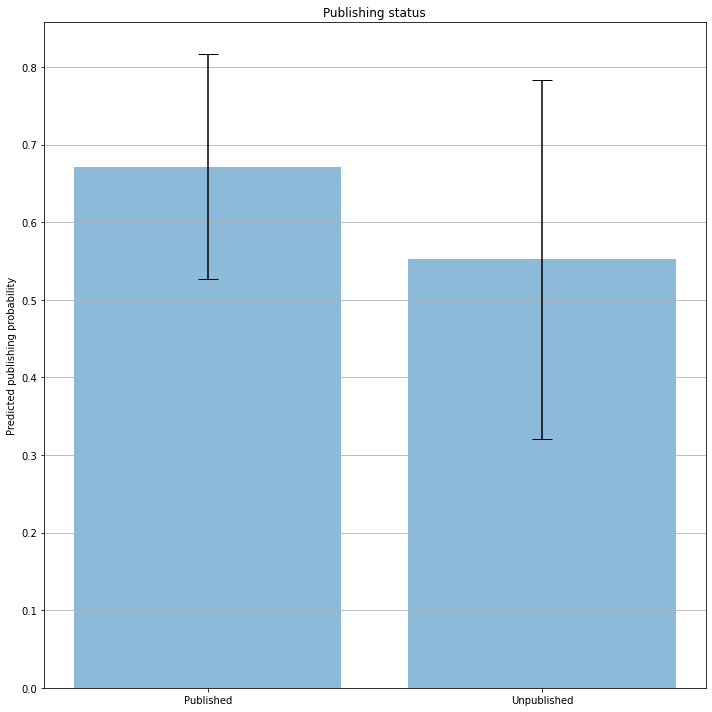

In [243]:
# Create lists for the plot
status = ['Published', 'Unpublished']
x_pos = np.arange(len(status))
CTEs = [X[X.is_preprint & X.is_published].pub_prob.mean(), X[X.is_preprint & ~X.is_published].pub_prob.mean()]
error = [X[X.is_preprint & X.is_published].pub_prob.std(), X[X.is_preprint & ~X.is_published].pub_prob.std()]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Predicted publishing probability')
ax.set_xticks(x_pos)
ax.set_xticklabels(status)
ax.set_title('Publishing status')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
fig3 = plt.gcf()
plt.draw()
fig3.savefig(inoutpath + "figs_dl_prediction_error_bar.pdf")
plt.show()

In [244]:
X_lxd.is_published.value_counts()

False    669
True      12
Name: is_published, dtype: int64

In [245]:
(X_lxd.pub_prob >= 0.592).value_counts()

True     446
False    235
Name: pub_prob, dtype: int64

In [246]:
X_lxd[X_lxd.pub_prob >= 0.592].is_published.value_counts()

False    436
True      10
Name: is_published, dtype: int64

In [253]:
len(X_lxd[X_lxd.is_published & (X_lxd.pub_prob >= 0.567)])#[['title', 'pub_prob', 'is_published']]

12

In [254]:
len(X_lxd[X_lxd.is_published & (X_lxd.pub_prob < 0.5)])# [['title', 'pub_prob', 'is_published']]

0

In [255]:
from sklearn.metrics import classification_report
target_names = ['Unpublished', 'Published']

print(classification_report(X_test.is_published, X_test.pub_prob >=0.5, target_names=target_names))

              precision    recall  f1-score   support

 Unpublished       0.66      0.37      0.47       852
   Published       0.81      0.93      0.86      2391

    accuracy                           0.78      3243
   macro avg       0.73      0.65      0.67      3243
weighted avg       0.77      0.78      0.76      3243



In [256]:
X_lxd.to_csv(inoutpath + "ret_lxd.ori_publishing_scores.csv")
X.to_csv(inoutpath + "ret.ori_publishing_scores.csv")

In [103]:
X_lxd['p_published'] = X_lxd.pub_prob > 0.592
X_lxd[X_lxd.p_published][['topic', 'p_published']].groupby('topic').count()

,p_published
topic,
Clinics,82
Drug discovery,118
Epidemiology,73
Genomics,140
Healthcare,72
Imaging,13


In [104]:
X_lxd[X_lxd.p_published].count()

title             498
abstract          498
journal           498
DOI               498
date              498
                 ... 
preprint_test     498
preprint_train    498
pubmed_train      498
pub_prob          498
p_published       498
Length: 138, dtype: int64

## Analyze prediction among Topics

<AxesSubplot:xlabel='topic'>

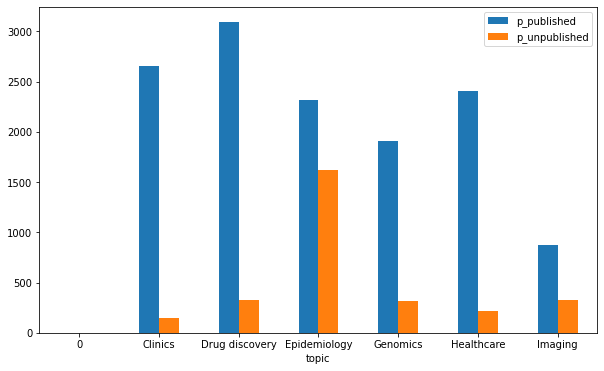

In [99]:
plt.rcParams['figure.figsize'] = [10, 6]

X['p_published'] = (X['pub_prob'] > 0.592) * 1
df_ret = pd.merge(X['topic'], X['p_published'], left_index=True, right_index=True)

topic_sum = df_ret.groupby('topic').agg({'topic':'count', 'p_published':'sum'})
topic_sum['p_unpublished'] = topic_sum['topic'] - topic_sum['p_published']
topic_sum[['p_published', 'p_unpublished']].plot.bar(rot=0)

<AxesSubplot:xlabel='topic'>

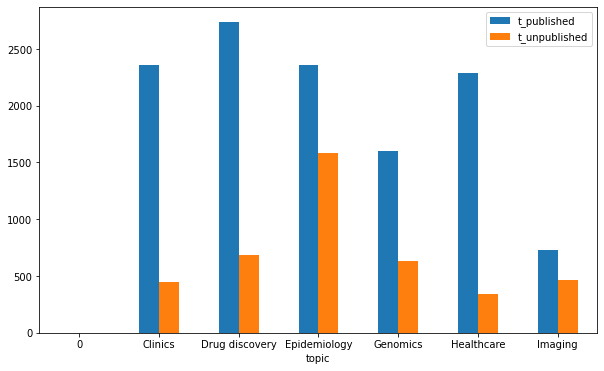

In [100]:
X['t_published'] = y * 1
df_t_ret = pd.merge(X['topic'], X['t_published'], left_index=True, right_index=True)

topic_t_sum = df_t_ret.groupby('topic').agg({'topic':'count', 't_published':'sum'})
topic_t_sum['t_unpublished'] = topic_t_sum['topic'] - topic_t_sum['t_published']
topic_t_sum[['t_published', 't_unpublished']].plot.bar(rot=0)

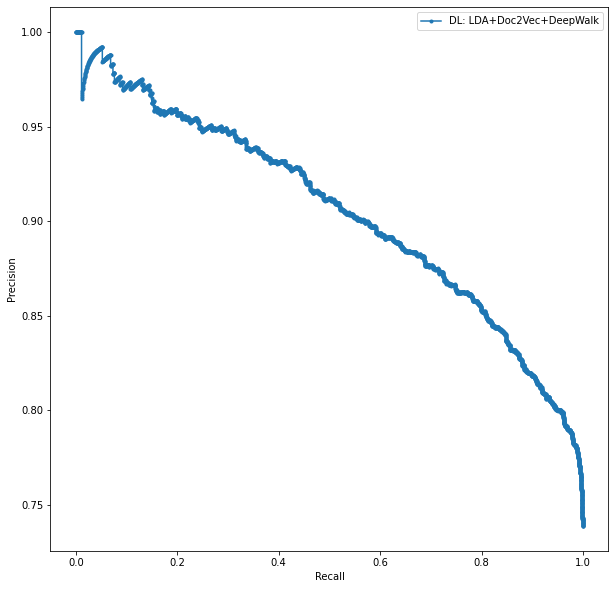

In [240]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(X_test.is_published, X_test.pub_prob)
plt.plot(recall, precision, marker='.', label='DL: LDA+Doc2Vec+DeepWalk')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
fig2 = plt.gcf()
plt.draw()
fig2.savefig(inoutpath + "figs_dl_precision_recall.pdf")
plt.show()